# Project 2

## MSDS7331: Data Mining
## Section 0403
## Summer 2018
- Anthony Schams
- Laura Ludwig  
- David Stroud
- Joshua Balson

## Data Preparation
### Define and Prepare Class Variables

#### Import the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import datetime as dt
import warnings
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
from __future__ import print_function
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df_train['text'] = df_train.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                                        str(row['project_essay_2']), 
                                                        str(row['project_essay_3']), 
                                                        str(row['project_essay_4'])]), axis=1
                                                      )                               

df = df_train

stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182080 entries, 0 to 182079
Data columns (total 20 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

#### Variable Clean-up

Due to a change in the application questions, we must combine the responses for two questions in the earlier period to equate to one response in the later period. Prior to the change, the first two questions asked the teacher to introduce their students using two questions: one about their classroom and another describing their students. The later format has one question requesting the teacher to describe their students. The third and fourth questions in the prior period asked about the project details, which is addressed in the second question in the later period. We combined the text to create two variables: student_desc and proj_desc, to capture these two topics in comparable variables. Once we've created those, we remove the project_essay_x variables from the dataframe.  

In [2]:
# Create comparable variables based on the changes to the application questions that happened during the middle of the time period
df['student_desc'] = np.where(df['project_submitted_datetime']<'2016-05-17',df['project_essay_1']+' '+df['project_essay_2'],df['project_essay_1'])
df['proj_desc'] = np.where(df['project_submitted_datetime']<'2016-05-17',df['project_essay_3']+' '+df['project_essay_4'],df['project_essay_2'])

# Remove attributes that arent useful
if 'project_essay_1' in df:
    del df['project_essay_1']
if 'project_essay_2' in df:    
    del df['project_essay_2']
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

Because one of our analysis tasks is to predict whether we can identify projects that address core academic competencies (reading, writing, and math), we create a variable called "three_r" to identify this as a category distinctly. We also add in the essay word lengths for essays one and two.  We perform a log transform on the continuous variables to correct for right-skew.  Finally, we create dummy variables for 'teacher_prefix' and 'project_grade_category'.

In [3]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
df["three_r"] = np.logical_or(df["project_subject_categories"].str.contains("Literacy & Language")
                             ,df["project_subject_categories"].str.contains("Math & Science")
                             )

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# extract length of each essay and title
df['essay1_DescribeStudents_len'] = df['student_desc'].apply(len)
df['essay2_AboutProject_len'] = df['proj_desc'].apply(len)
df['title_len'] = df['project_title'].apply(len)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)
df['essay1_DescribeStudents_len']=np.log1p(df.essay1_DescribeStudents_len)
df['essay2_AboutProject_len']=np.log1p(df.essay2_AboutProject_len)
df['title_len']=np.log1p(df.title_len)

# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(df.teacher_prefix,prefix='teacher_prefix')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.project_grade_category,prefix='project_grade_category')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved'
        ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2'
        ,'essay1_DescribeStudents_len','essay2_AboutProject_len','title_len','text'
        ,'three_r','student_desc','proj_desc']]
  
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 14 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
teacher_prefix_Teacher                          182073 non-null uint8
project_grade_category_Grades PreK-2            182073 non-null uint8
essay1_DescribeStudents_len                     182073 non-null float64
essay2_AboutProject_len                         182073 non-null float64
title_len                                       182073 non-null float64
text                                            182073 non-null object
three_r                                         182073 non-null bool
student_desc                       

,teacher_number_of_previously_posted_projects,Total_Cost,True_Quantity,Average_item_cost,project_is_approved,teacher_prefix_Teacher,project_grade_category_Grades PreK-2,essay1_DescribeStudents_len,essay2_AboutProject_len,title_len
count,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000
mean,1.440580,6.021158,2.330753,3.916123,0.847676,0.021486,0.405821,6.486513,6.696629,3.429738
std,1.318374,0.740747,1.039543,1.282055,0.359335,0.144998,0.491052,0.274325,0.294957,0.407495
min,0.000000,4.313212,0.693147,0.230229,0.000000,0.000000,0.000000,4.304065,5.517453,1.609438
25%,0.000000,5.514759,1.609438,2.891869,1.000000,0.000000,0.000000,6.261492,6.466145,3.135494
50%,1.098612,5.990964,2.302585,3.848531,1.000000,0.000000,0.000000,6.424869,6.608001,3.433987
75%,2.302585,6.549365,3.091042,4.918228,1.000000,0.000000,1.000000,6.680855,6.875232,3.737670
max,6.113682,9.700169,7.247793,9.210340,1.000000,1.000000,1.000000,7.923348,8.561210,4.955827


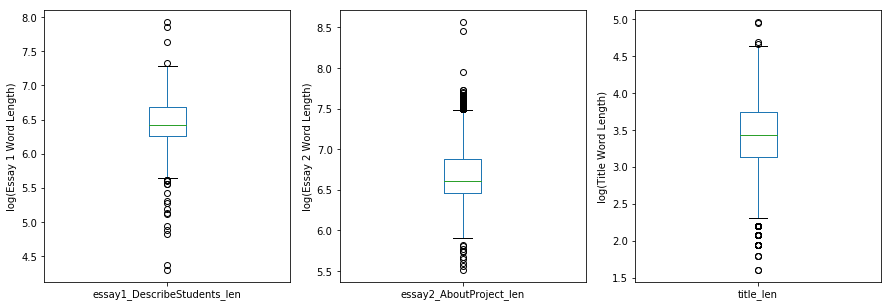

In [4]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
df.essay1_DescribeStudents_len.plot(kind='box')
plt.ylabel('log(Essay 1 Word Length)')
plt.subplot(1,3,2)
df.essay2_AboutProject_len.plot(kind='box')
plt.ylabel('log(Essay 2 Word Length)')
plt.subplot(1,3,3)
df.title_len.plot(kind='box')
plt.ylabel('log(Title Word Length)')
plt.show()

The boxplots above show the three new features added to this data set after the log transform has been applied

### Describing the Final Dataset

In [23]:
# Need description here, maybe a few visualizations

## Modeling and Evaluation

### Evaluation Metrics

#### Method to evaluate all models

In [5]:
def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall','f1']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()
    f1avg = scores['test_f1'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"
    print_str4 = "The average F1 for all cv folds is: \t\t\t\t {f1avg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print(print_str4.format(f1avg=f1avg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    scoresResults['F1'] = scores['test_f1']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

### Training and Testing Splits

In [6]:
def EvaluateClassifierEstimator3(classifierEstimator, X, y, cv):
    
    #https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        classifierEst.fit(X[train_indices],y[train_indices])  # train object
        y_hat = classifierEst.predict(X[test_indices]) # get test set precitions

        # print the accuracy and confusion matrix 
        print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))


### Classification/Regression Models
We will create three different models for two different tasks.

-Task1:  predict whether an application will be approved or declined

-Task2:  predict whether an application project is one of the three Rs (Reading, Writing, Arithmetic) based on the essay text

#### Task 1:  Predicting Application Approval
##### Set Variables for Task1

In [7]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# we want to predict the X and y data as follows:
y = df['project_is_approved'].values # get the labels we want
X = df[['teacher_number_of_previously_posted_projects'
       ,'Total_Cost'
       ,'True_Quantity'
       ,'Average_item_cost'
       ,'teacher_prefix_Teacher'
       ,'project_grade_category_Grades PreK-2'
       ,'essay1_DescribeStudents_len'
       ,'title_len'
       #,'text'
       ,'three_r'
       #,'student_desc'
        #,'proj_desc'
       ]].values # use these to predict

##### Logistic Regression Classification

In [8]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#Use the best parameters for our Linear Regression object
classifierEst = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                                   fit_intercept=True, intercept_scaling=1, max_iter=100,
                                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
                                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
print(EvaluateClassifierEstimator(classifierEst, X, y, cv))
print(EvaluateClassifierEstimator2(classifierEst, X, y, 10))
print(EvaluateClassifierEstimator3(classifierEst, X, y, cv))

The average accuracy for all cv folds is: 			 0.56639
The average precision for all cv folds is: 			 0.88744
The average recall for all cv folds is: 			 0.56021
The average F1 for all cv folds is: 				 0.68683
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall        F1
0  0.568102   0.888696  0.561793  0.688406
1  0.570573   0.892358  0.562003  0.689661
2  0.559589   0.882456  0.553639  0.680403
3  0.572276   0.891457  0.565678  0.692150
4  0.561951   0.885732  0.556173  0.683291
5  0.568322   0.884275  0.563753  0.688540
6  0.560248   0.884189  0.553120  0.680525
7  0.569365   0.891060  0.562472  0.689625
8  0.570903   0.888314  0.566100  0.691515
9  0.562555   0.885843  0.557357  0.684217
             precision    recall  f1-score   support

          0       0.20      0.60      0.30     27734
          1       0.89      0.56      0.69    154339

avg / total       0.78      0.57      0.63    182073

[[16

##### Decision Tree Classification

In [9]:
regEstimator = DecisionTreeClassifier()

parameters = { 'criterion':['gini','entropy']
              ,'splitter': ['best','random']
              ,'class_weight': ['balanced',None]
             }

#Create a grid search object
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)
regGridSearch.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:   53.9s finished


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
classifierEst = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, presort=False, random_state=None,
                                       splitter='best')

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
print(EvaluateClassifierEstimator(classifierEst, X, y, cv))
print(EvaluateClassifierEstimator2(classifierEst, X, y, 10))
print(EvaluateClassifierEstimator3(classifierEst, X, y, cv))

The average accuracy for all cv folds is: 			 0.75293
The average precision for all cv folds is: 			 0.85399
The average recall for all cv folds is: 			 0.85513
The average F1 for all cv folds is: 				 0.85456
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall        F1
0  0.754558   0.854828  0.856431  0.855629
1  0.748517   0.852469  0.851090  0.851779
2  0.755163   0.851914  0.860423  0.856147
3  0.757195   0.857106  0.857272  0.857189
4  0.753954   0.854516  0.856173  0.855344
5  0.749780   0.851181  0.853611  0.852394
6  0.753570   0.853457  0.855948  0.854700
7  0.748737   0.854700  0.848906  0.851793
8  0.755053   0.855106  0.856875  0.855990
9  0.752746   0.854651  0.854541  0.854596
             precision    recall  f1-score   support

          0       0.18      0.18      0.18     27734
          1       0.85      0.85      0.85    154339

avg / total       0.75      0.75      0.75    182073

[[  

##### Naive Bayes - Multinomial

In [11]:
regEstimator = MultinomialNB()

parameters = { 'alpha':[0, 0.25, 0.5, 0.75, 1]
              ,'fit_prior': [1,0]
              #,'class_prior': ['balanced',None]
             }

#Create a grid search object
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)
regGridSearch.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.6s finished


MultinomialNB(alpha=0, class_prior=None, fit_prior=1)

In [12]:
classifierEst = MultinomialNB(alpha=0, class_prior=None, fit_prior=1)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
print(EvaluateClassifierEstimator(classifierEst, X, y, cv))
print(EvaluateClassifierEstimator2(classifierEst, X, y, 10))
print(EvaluateClassifierEstimator3(classifierEst, X, y, cv))

The average accuracy for all cv folds is: 			 0.84882
The average precision for all cv folds is: 			 0.84882
The average recall for all cv folds is: 			 1.0
The average F1 for all cv folds is: 				 0.91823
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision  Recall        F1
0  0.849242   0.849242     1.0  0.918476
1  0.849022   0.849022     1.0  0.918347
2  0.846771   0.846771     1.0  0.917028
3  0.850011   0.850011     1.0  0.918925
4  0.849627   0.849627     1.0  0.918701
5  0.846386   0.846386     1.0  0.916803
6  0.846771   0.846771     1.0  0.917028
7  0.850560   0.850560     1.0  0.919246
8  0.849572   0.849572     1.0  0.918669
9  0.850286   0.850286     1.0  0.919086
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     27734
          1       0.85      1.00      0.92    154339

avg / total       0.72      0.85      0.78    182073

[[     0  27734]
 [     0 1543

#### Task 2: Predicting Core Academic Competency Projects (Reading, Writing, Math)
##### Set Variables for Task2

In [13]:
# we want to predict the X and y data as follows:
y = df['three_r'].values # get the labels we want

# Create and fit our Tfidf Vectorizer
vectorizer = TfidfVectorizer()
x_textVect = vectorizer.fit_transform(df['text'])

##### Logistic Regression Classification

In [15]:
#Logisitic regression 10-fold cross-validation 
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced',None]
              ,'random_state': [0]
              ,'solver': ['sag'] #['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_textVect, y)
regGridSearch.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 13.5min
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed: 78.8min finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#Use the best parameters for our Linear Regression object
classifierEst = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                                   intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                                   penalty='l2', random_state=0, solver='sag', tol=0.0001,
                                   verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
print(EvaluateClassifierEstimator(classifierEst, x_textVect, y, cv))
print(EvaluateClassifierEstimator2(classifierEst, x_textVect, y, 10))
print(EvaluateClassifierEstimator3(classifierEst, x_textVect, y, cv))

The average accuracy for all cv folds is: 			 0.87132
The average precision for all cv folds is: 			 0.88899
The average recall for all cv folds is: 			 0.93318
The average F1 for all cv folds is: 				 0.91055
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall        F1
0  0.870991   0.888488  0.931947  0.909699
1  0.870387   0.889477  0.931433  0.909972
2  0.871375   0.886423  0.936329  0.910692
3  0.869123   0.886742  0.932843  0.909209
4  0.868409   0.884794  0.932624  0.908079
5  0.871650   0.889913  0.933271  0.911076
6  0.871540   0.890110  0.933136  0.911115
7  0.871870   0.889352  0.934010  0.911134
8  0.873517   0.894219  0.931481  0.912470
9  0.874341   0.890415  0.934757  0.912047
             precision    recall  f1-score   support

      False       0.82      0.72      0.77     54186
       True       0.89      0.93      0.91    127887

avg / total       0.87      0.87      0.87    182073

[[ 3

##### Random Forest Classification

In [17]:
regEstimator = RandomForestClassifier()

parameters = { 'n_estimators':[5, 10, 25, 50]
              ,'criterion': ['gini','entropy']
              #,'n_jobs': [-1]
              ,'class_weight': ['balanced',None]
             }

#Create a grid search object
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_textVect, y)
regGridSearch.best_estimator_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 70.3min
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed: 327.3min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
classifierEst = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                       criterion='entropy', max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       min_impurity_split=None, min_samples_leaf=1,
                                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                                       n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
                                       verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
print(EvaluateClassifierEstimator(classifierEst, x_textVect, y, cv))
print(EvaluateClassifierEstimator2(classifierEst, x_textVect, y, 10))
print(EvaluateClassifierEstimator3(classifierEst, x_textVect, y, cv))

The average accuracy for all cv folds is: 			 0.8434
The average precision for all cv folds is: 			 0.8414
The average recall for all cv folds is: 			 0.95734
The average F1 for all cv folds is: 				 0.89563
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall        F1
0  0.841718   0.838134  0.958018  0.894075
1  0.843201   0.841455  0.957439  0.895708
2  0.840235   0.836386  0.959617  0.893774
3  0.842047   0.839671  0.958096  0.894983
4  0.840125   0.837184  0.956659  0.892943
5  0.849407   0.849190  0.956034  0.899450
6  0.844189   0.843420  0.956799  0.896539
7  0.842597   0.840774  0.957517  0.895356
8  0.845343   0.845394  0.956390  0.897473
9  0.845123   0.842386  0.956820  0.895964
             precision    recall  f1-score   support

      False       0.85      0.57      0.68     54186
       True       0.84      0.96      0.90    127887

avg / total       0.84      0.84      0.83    182073

[[ 310

##### Naive Bayes - Multinomial

In [34]:
regEstimator = MultinomialNB()

parameters = { 'alpha':[0, 0.25, 0.5, 0.75, 1]
              ,'fit_prior': [1,0]
              #,'class_prior': ['balanced',None]
             }

#Create a grid search object
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_textVect, y)
regGridSearch.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   56.1s finished


MultinomialNB(alpha=0.75, class_prior=None, fit_prior=0)

In [35]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
classifierEst = MultinomialNB(alpha=0.75, class_prior=None, fit_prior=0)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
print(EvaluateClassifierEstimator(classifierEst, x_textVect, y, cv))
print(EvaluateClassifierEstimator2(classifierEst, x_textVect, y, 10))
print(EvaluateClassifierEstimator3(classifierEst, x_textVect, y, cv))

The average accuracy for all cv folds is: 			 0.84861
The average precision for all cv folds is: 			 0.89095
The average recall for all cv folds is: 			 0.89368
The average F1 for all cv folds is: 				 0.89231
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall        F1
0  0.845947   0.888767  0.890517  0.889641
1  0.847100   0.890743  0.891995  0.891369
2  0.846112   0.886567  0.894770  0.890649
3  0.848089   0.890412  0.893753  0.892080
4  0.847430   0.889684  0.891647  0.890664
5  0.852482   0.894078  0.896866  0.895470
6  0.847704   0.890647  0.893905  0.892273
7  0.850450   0.891443  0.896525  0.893977
8  0.849187   0.894193  0.892527  0.893359
9  0.851604   0.892989  0.894256  0.893622
             precision    recall  f1-score   support

      False       0.75      0.74      0.74     54186
       True       0.89      0.89      0.89    127887

avg / total       0.85      0.85      0.85    182073

[[ 4

### Analyze Results of Chosen Models

In [ ]:
#need something here

### Model Advantages

In [ ]:
#need something here

### Model Attribute Importance

In [ ]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X[train_indices]) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data. It uses the last iteration of the loop above for the split.

X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
X_test_scaled = scl_obj.transform(X[test_indices]) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)  
lr_clf.fit(X_train_scaled,y[train_indices])  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y[test_indices],y_hat)
conf = mt.confusion_matrix(y[test_indices],y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

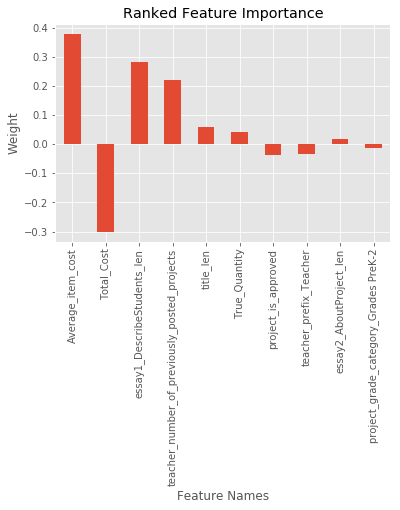

In [96]:
# now let's make a pandas Series with the names and values, and plot them
# reference for code: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = lr_clf.coef_.ravel()
feature_names = df.columns.values

logreg_features = pd.DataFrame({'feature_names': feature_names[:10], 'weights': weights, 'absolute_weights':np.abs(weights)})
logreg_features.sort_values(by='absolute_weights', inplace=True, ascending = False)

weights = pd.Series(logreg_features['weights'].values, index=logreg_features['feature_names'])
px = weights.plot(kind='bar')
px.set_xlabel("Feature Names")
px.set_ylabel("Weight")
px.set_title("Ranked Feature Importance")
plt.show()

## Deployment

In [ ]:
#need something here

## Exceptional Work

In [79]:
#need something here